In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import colorsys
import random

In [2]:
def erosion(image,diameter):
    img=np.pad(image,((diameter//2,diameter//2),(diameter//2,diameter//2)),'constant')
    out=np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            out[i,j]=np.min(img[i:i+diameter,j:j+diameter])
    return out

In [3]:
def dialation(image,diameter):
    img=np.pad(image,((diameter//2,diameter//2),(diameter//2,diameter//2)),'constant')
    out=np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            out[i,j]=np.max(img[i:i+diameter,j:j+diameter])
    return out

Text(0.5, 1.0, 'Image after performing Opening')

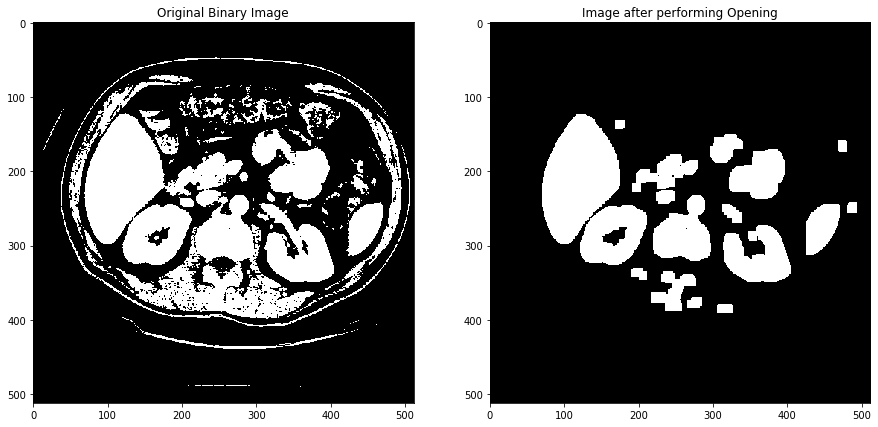

In [4]:
image=cv.cvtColor(cv.imread('../images/kidney.jpg'),cv.COLOR_BGR2GRAY)
(T,binary_image)=cv.threshold(image,128,255,cv.THRESH_BINARY)
binary_image=binary_image//255
opened_image=dialation(erosion(binary_image,11),11)
f, axarr = plt.subplots(1,2,figsize=(15,10))
axarr[0].imshow(binary_image,cmap="gray")
axarr[1].imshow(opened_image,cmap="gray")
axarr[0].set_title("Original Binary Image")
axarr[1].set_title("Image after performing Opening")

### Approach : -
1. First the given image is thresholded and converted to binary Image
2. Then the Opening is perfomed on resulted binary image (Erosion followed by Dilation)
3. Then Two Pass Algorithm is performed to get the segments seperated 
4. Clustermap.size gives number of clusters present and we assign that many colors to each segment
5. By assigning colors to segments we get final color image

In [5]:
def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.4
    hsv = [(i/(N+1), i/2*N, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    return np.array(colors)      

In [6]:
def TPA(image):
    cluster=np.zeros(image.shape,dtype=np.int64)
    count=0
    #First Pass of the Two Pass Algorithm
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if i==0:
                if j==0 and image[i,j]==1:
                    cluster[i,j]=count   
                else:
                    if image[i,j]==1 and image[i,j-1]==1:
                        cluster[i,j]=cluster[i,j-1]
                    elif image[i,j]==1:
                        count=count+1
                        cluster[i,j]=count
            else:
                if j==0 and image[i,j]==1 and image[i-1,j]==1:
                    cluster[i,j]=cluster[i-1,j]
                elif j==0 and image[i,j]==1:
                    count=count+1
                    cluster[i,j]=count
                elif image[i,j]==1 and image[i-1,j]==1 and image[i,j-1]==1:
                    cluster[i,j]=min(cluster[i-1,j],cluster[i,j-1])
                 
                elif image[i,j]==1 and image[i-1,j]==1 and image[i,j-1]==0:
                    cluster[i,j]=cluster[i-1,j]
                elif image[i,j]==1 and image[i-1,j]==0 and image[i,j-1]==1:
                    cluster[i,j]=cluster[i,j-1]
                elif image[i,j]==1 and image[i-1,j]==0 and image[i,j-1]==0:
                    count=count+1
                    cluster[i,j]=count
    
    mapping=np.arange(count+1)
    
    #Second Passs of the Two Pass ALgorithm
    for i in range(1,image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]==1:
                if j==0:
                    if cluster[i-1,j]!=cluster[i,j] and image[i-1,j]==1 and image[i,j]==1:
                        mapping[max(cluster[i,j],cluster[i-1,j])]=min(cluster[i,j],cluster[i-1,j])
                else:
                    if cluster[i-1,j]!=cluster[i,j] and image[i-1,j]==1 and image[i,j]==1:
                        mapping[max(cluster[i,j],cluster[i-1,j])]=min(cluster[i,j],cluster[i-1,j])
                    if cluster[i,j]!=cluster[i,j-1] and image[i,j-1]==1 and image[i,j]==1:
                        mapping[max(cluster[i,j],cluster[i,j-1])]=min(cluster[i,j],cluster[i,j-1])


#     Finding Root of the Union - Find
    for i in range(count+1):
        if i!=mapping[i]:
            temp=i
            val=mapping[i]
            while temp!=val:
                temp=val
                val=mapping[temp]
            mapping[i]=val
    
    result=cluster.copy()      
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            result[i,j]=mapping[cluster[i,j]]
    return [result,mapping]              

In [7]:
[twopass_image,clustermap]=TPA(opened_image)

In [8]:
#Conversion to color image
colors = random_colors(clustermap.size)
segmented_image = np.zeros((twopass_image.shape[0],twopass_image.shape[1],3),dtype=np.uint8)

for i in range(twopass_image.shape[0]):
    for j in range(twopass_image.shape[1]):
        if twopass_image[i,j]==0:
            segmented_image[i,j,:] = 0
        else:
            segmented_image[i,j,:] = colors[twopass_image[i,j]]
            segmented_image[i,j,:] *= 255

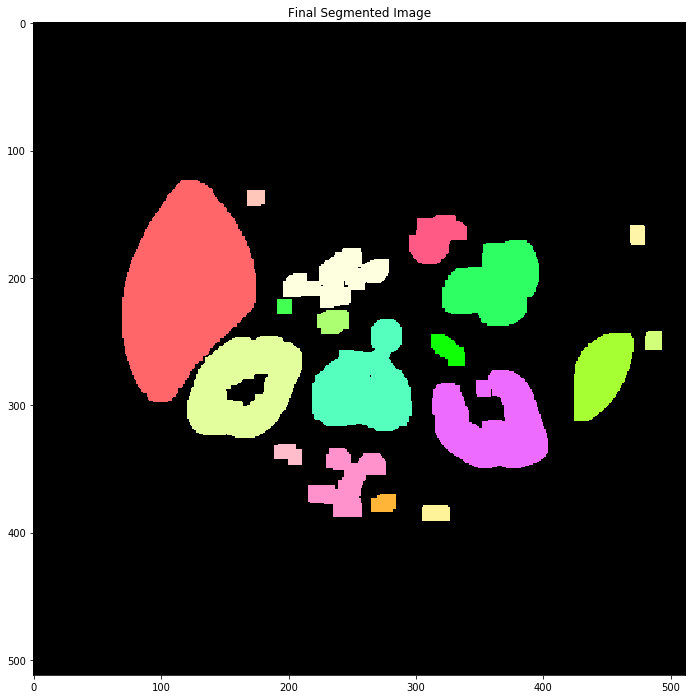

In [9]:
plt.figure(figsize=(12,12))
plt.imshow(segmented_image)
plt.title("Final Segmented Image")
plt.show()